In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
from src.API_Wrapper import API
from src.Reporter import Reporter
from src.Data_Generator import Data_Generator
from src.Simulator import Simulator
# Creds
LEAGUE_ID = '65522'
USER_AGENT = 'brayps_user_agent'
# Current week of the season
week = 1
# Number of seasons to run
n = 200
# Instatiate Classes
api = API(leagueid=LEAGUE_ID, user_agent=USER_AGENT)
rep = Reporter(api, week)
dg = Data_Generator(week, api, rep, n)
sim = Simulator(week, api, rep, dg, n)

# Fantasy Football Simulation
*Created by Patrick Bray*

The following paper describes the functionality of a fantasy football simulator for the MyFantasyLeague (MFL) 2021 season

## Abstract
Fantasy football is a popular online competition where participants select NFL players to play for their virtual football teams. Fantasy teams go head to head with another team in their league each week. As NFL players accumulate statistics through their onfield performance, the team who selected that player recieves fantasy points. 

This program simulates the performances of NFL players throughout the 2021 season and attributes their performances to a specified MFL team. This program sets itself apart from other fantasy simulators because it accounts for variations in player performance as well as correlations between player performances. Approaching this problem from a simulation instead of an analytical standpoint captures more nuanced aspects of fantasy football strategy and provides a platform for niche analyses.

## Background
This paper will explain the reason why one would approach fantasy simulation in this fashion as well as the explanation of how it was accomplished.

### Mean Player Performance
Predicting fantasy player performance within a given week or year is a well-established and expert-powered analytical task. This program takes advantage of the predictions made by fantasy football [experts](https://www.fantasypros.com/nfl/projections/qb.php) for the 2021 season to predict its weekly mean scores for each player. The season projection is divided by the number of weeks remaining in the season and adjusted based on the difficulty of the player's opponent. Some defenses allow more points to offensive players than others, because of this I adjusted the expected player performance based on the quality of defense they were facing for the week.


$ OpponentCoefficient =  \frac{Opponent Points Allowed for Position X}{Average Points Allowed for Position X} $


$ Expected Points  = \frac{Expert Projections}{RemainingWeeks} * OpponentCoefficient $

### Random Score Generation
Player performances are assumed to follow a normal distribution around the mean described in the above section. Random variates within the same NFL game are generated together to account for correlation between players in the same game.
Variance of each player's performance along with their correlation are used to develop a covariance matrix for each game, generating a random score for each player.

$ Cov(A, B) = Corr(A, B) * \sqrt{Var(A)*Var(B)} $

#### Variation in Player Performance
Fantasy player performances often deviate from the expected scores assigned to them, and some vary more often than others. The prediction of player score variance was not part of this analysis but is a future consideration for the model. Currently, variance is predicted by depth chart position.

In [2]:
dg.vars_df

,QB1,RB1,RB2,WR1,WR2,WR3,TE1
0,11.0,8.0,7.0,10.0,8.5,8.0,7.0


*Figure 1: Variance in player performance by depth chart position. Credit: [Pro Football Focus](https://www.pff.com/news/fantasy-football-fantasy-football-using-variance-to-identify-2020-best-ball-draft-targets)*

#### Correlation Between Player Performances
Fantasy points are not scored in a vaccuum, and player's performances can influence each other. This may seem trivial but it can seriously impact the chances of one team winning a game.

Imagine your team is behind by a significant number of points. You have two players remaining, a Quarterback and a Wide Reciever. Both players would need to score on the higher end of their epected point totals for you to win the game. Your chances to win are slim, however, your chances are better if these two players are **on the same team**.

This is because fantasy player performances are not independent, a touchdown pass from a quarterback to a wide reciever results in points for both players. This analysis even captures more subtle relationships, one well performing quarterback encourages faster and more aggressive play from their opponent, increasing fantasy points.

In [3]:
dg.corr_df.style.background_gradient(cmap ='coolwarm')

,QB1,RB1,RB2,WR1,WR2,WR3,TE1,OPP_QB1,OPP_RB1,OPP_RB2,OPP_WR1,OPP_WR2,OPP_WR3,OPP_TE1
QB1,1.000000,0.140000,0.030000,0.400000,0.310000,0.270000,0.320000,0.210000,-0.010000,-0.080000,0.090000,0.160000,0.120000,0.110000
RB1,0.140000,1.000000,-0.010000,0.060000,-0.030000,-0.040000,-0.050000,-0.010000,-0.020000,-0.050000,0.030000,0.010000,0.030000,0.010000
RB2,0.030000,-0.190000,1.000000,-0.060000,-0.030000,-0.080000,-0.020000,-0.080000,-0.050000,-0.090000,-0.010000,-0.020000,0.010000,-0.020000
WR1,0.400000,0.060000,-0.060000,1.000000,0.020000,0.020000,0.010000,0.090000,0.030000,-0.010000,0.050000,0.050000,0.040000,0.030000
WR2,0.310000,-0.030000,-0.030000,0.020000,1.000000,0.040000,-0.040000,0.160000,0.010000,-0.020000,0.050000,0.090000,0.090000,0.090000
WR3,0.270000,-0.040000,-0.080000,0.020000,0.040000,1.000000,0.030000,0.120000,0.030000,0.010000,0.040000,0.070000,0.010000,0.030000
TE1,0.320000,-0.050000,-0.020000,0.010000,-0.040000,0.030000,1.000000,0.110000,0.010000,-0.020000,0.030000,0.090000,0.030000,0.010000
OPP_QB1,0.210000,-0.010000,-0.080000,0.090000,0.160000,0.120000,0.110000,1.000000,0.140000,0.030000,0.400000,0.310000,0.270000,0.320000
OPP_RB1,-0.010000,-0.020000,-0.050000,0.030000,0.010000,0.030000,0.010000,0.140000,1.000000,-0.010000,0.060000,-0.030000,-0.040000,-0.050000
OPP_RB2,-0.080000,-0.050000,-0.090000,-0.010000,-0.020000,0.010000,-0.020000,0.030000,-0.190000,1.000000,-0.060000,-0.030000,-0.080000,-0.020000


*Figure 2: Correlation between fantasy football performances. Credit: [fantasymath.com](https://fantasymath.com/posts/correlation/)*

## Simulation
The simulation occurs in two parts: the generation of n possible NFL player scores (which occur independently from the actions of wannabe internet GMs) and the simulation of n MFL seasons.

### Generate NFL Scores
NFL player scores are generated using the methodology described in the above section. Within the program, a dataframe is populated with each player for each week and a list of randomly generated scores based on their random variable for the week. 

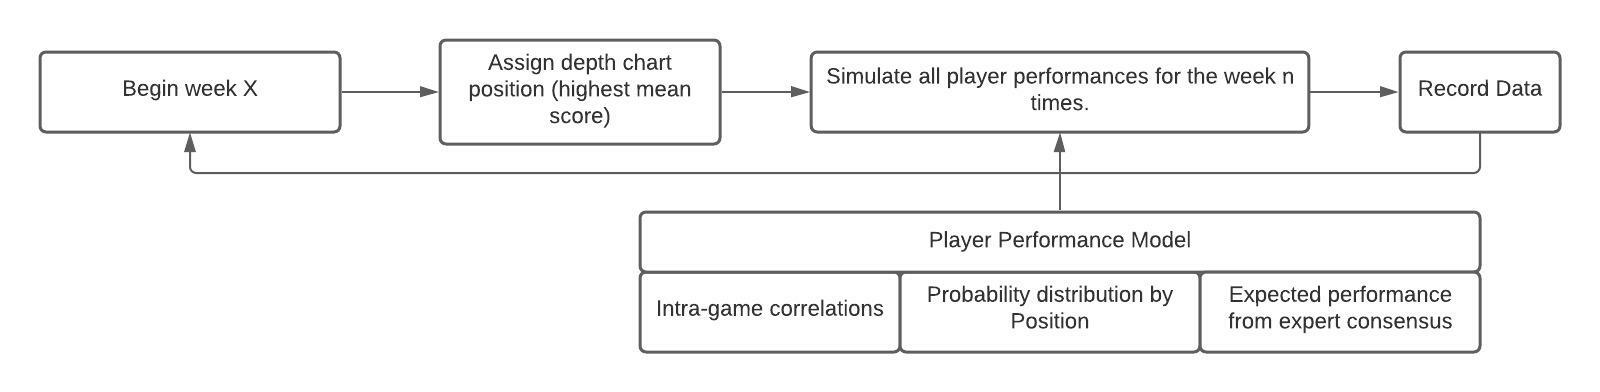

In [4]:
Image("Fantasy League Simulation.jpeg", height=400, width=800)

*Figure 3: Generation of random NFL player performances in simulation*

In [5]:
display(dg.score_df)

,id_franchise,player_status,player_id,position,name_player,id_player,team,name_franchise,week,opp,weeks_remaining,norm_name_player,mean_pts,pos_rank,fran_pos_rank,start,flex_rank,pts
0,0001,ROSTER,10703,QB,Russell Wilson,10703,SEA,The Youth Academy,1,IND,18,russellwilson,17.035459,QB1,2,False,NaN,"[-0.40561421825204746, 8.822290066937912, 1.21..."
1,0001,ROSTER,10703,QB,Russell Wilson,10703,SEA,The Youth Academy,2,TEN,18,russellwilson,21.244219,QB1,1,True,NaN,"[8.629742182437209, 12.614915706969683, 22.279..."
2,0001,ROSTER,10703,QB,Russell Wilson,10703,SEA,The Youth Academy,3,MIN,18,russellwilson,17.837127,QB1,2,False,NaN,"[22.935252610586446, 4.479751742199305, 20.124..."
3,0001,ROSTER,10703,QB,Russell Wilson,10703,SEA,The Youth Academy,4,SFO,18,russellwilson,16.734833,QB1,2,False,NaN,"[15.782460135999624, 5.96756580244192, 8.31656..."
4,0001,ROSTER,10703,QB,Russell Wilson,10703,SEA,The Youth Academy,5,LAR,18,russellwilson,13.528158,QB1,2,False,NaN,"[8.85260982320274, 16.55404603461971, 11.14557..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6277,0012,ROSTER,14072,RB,Benny Snell,14072,PIT,Rodger Goodella,14,MIN,18,bennysnell,3.170247,RB1,2,True,NaN,"[11.553600707166547, 12.313253480883276, 8.952..."
6278,0012,ROSTER,14072,RB,Benny Snell,14072,PIT,Rodger Goodella,15,TEN,18,bennysnell,3.053371,RB1,2,True,NaN,"[10.594898563884671, 10.05312751494807, 6.7191..."
6279,0012,ROSTER,14072,RB,Benny Snell,14072,PIT,Rodger Goodella,16,KCC,18,bennysnell,2.892667,RB1,3,False,8.0,"[6.429039801247026, 6.303518468376976, 5.79998..."
6280,0012,ROSTER,14072,RB,Benny Snell,14072,PIT,Rodger Goodella,17,CLE,18,bennysnell,2.337509,RB1,2,True,NaN,"[6.42345007361265, 6.832335198377463, 7.406532..."


*Figure 4: Each player-week with random score values generated*

### Simulate MFL Seasons
MFL seasons are simulated using roster and schedule information from the myfantasyleague.com [api](https://api.myfantasyleague.com/2020/api_info?STATE=details). 12 teams in the league face off against each other 13 times throughout the NFL season. After the regular season is concluded, the top 6 teams play in a single-elimnation tournament for the championship. The simulator plays through each week of the season using the point values generated 

In [6]:
sim.matchup_df

,run,week,id0,team0_pts,id1,team1_pts,winner
0,0,1,0009,76.416656,0012,81.248894,0012
1,0,1,0006,83.105028,0002,66.604457,0006
2,0,1,0010,77.708926,0001,61.921745,0010
3,0,1,0003,79.601197,0008,105.368872,0008
4,0,1,0004,47.513329,0005,67.604509,0005
...,...,...,...,...,...,...,...
15595,199,13,0002,46.609301,0011,68.813697,0011
15596,199,13,0012,40.491180,0004,58.823887,0004
15597,199,13,0006,61.013603,0001,68.259117,0001
15598,199,13,0005,70.009086,0009,63.790928,0005


*Figure 5: Each MFL game played within the simulation*

In [7]:
sim.team_df

,total_wins,average_wins,total_pts,mean_ppg,std_ppg,max_game,min_game
team,,,,,,,
0001,2050,10.250,173188.869831,133.027348,27.890524,232.960745,42.772324
0002,1608,8.040,168160.563113,129.065971,28.305876,230.224471,39.932689
0003,1297,6.485,163414.276904,125.640101,30.128698,230.164609,28.924978
0004,1388,6.940,157072.864145,120.875928,26.008737,208.130042,29.922065
0005,946,4.730,136679.005574,104.622595,27.223565,197.017279,18.828140
0006,841,4.205,136332.044711,105.052419,27.921998,202.220232,10.663864
0007,1537,7.685,159491.590596,122.582250,31.434711,220.357643,26.803465
0008,1245,6.225,146882.926843,112.775301,30.437174,209.561816,19.470863
0009,1150,5.750,148623.381031,114.488920,28.399861,223.719883,22.366801


*Figure 6: Performance of each roster over n seasons*

## Architecture

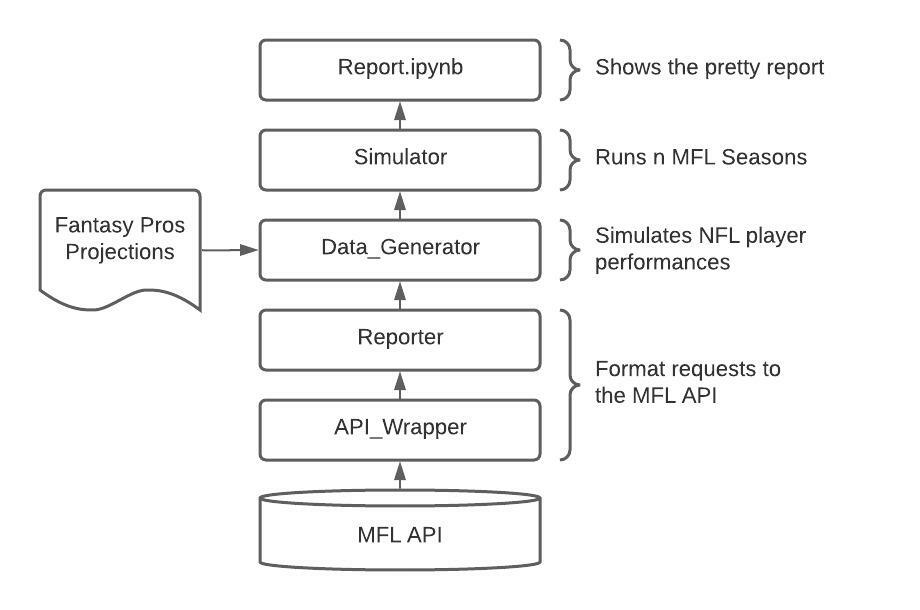

In [8]:
Image("Fantasy League Simulation - Page 2.jpeg", height=1000, width=800)

*Fig 7: file structure of the MFL simulation program*

## Conclusion
Simulation proves to be a useful tool for collecting a variety of data from complex processes. The flexibility of this simulator allows one to consider complex interactions between player performances when simulating team performance. This methodology could be used to evaluate trade effects, determine the effects of injuries on a team's performance, or advise sit-start decisions. 

In the future, I would like to simulate the playoffs of the league to report the chance's each team has of a championship, as well as a playoff appearance. Additionally, I plan to improve the generation of random variables by collecting expert projections by week and mapping those projections to real performances. This would allow depth chart position, expected performance, past variance and age to generate more accurate random scores for NFL players. I would also like to include the correlation of player performances from week to week, to capture players having breakout seasons. Finally, I would like to fit player performance to a non-normal distribution, as there is a major dropoff at 0 points and likely a large right tail in the true fantasy points pdf.

## Appendix
### Running the Code
1. Download Python 3.8 or Anaconda
2. Unzip/Clone the folder of this repository
2. Open python environment and run from the directory of the repo
`pip install -r requirements.txt`

4. Run all cells of 'Report.ipynb'

A similar implementation was made at [fantasymath.com](fantasymath.com)
